In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import io
import os

In [ ]:
def is_barcode(rect):
    x,y,w,h = rect
    area = w * h
    result = (x > 10 and y > 10 and w > 10 and h > 40 and area > 1000)
    if result:
        print ('rectangle size: x=%s y=%s w=%s h=%s' %(x,y,w,h))
    return result

In [ ]:
def create_mask(original):
    copied = np.copy(original)
    #original = cv2.normalize(original, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    #img_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    #img_blur = cv2.GaussianBlur(img_gray,(5,5),0)
    #img_bgr = cv2.cvtColor(img_blur,cv2.COLOR_GRAY2BGR)
    
    img_hsv = cv.cvtColor(original, cv.COLOR_BGR2HSV)

    lowHue = 0
    lowSat = 0
    lowVal = 2
    highHue = 255
    highSat = 55
    highVal = 250

    # creation of mask
    colorLow = np.array([lowHue,lowSat,lowVal])
    colorHigh = np.array([highHue,highSat,highVal])
    img_mask = cv.inRange(img_hsv, colorLow, colorHigh)
    # find and draw contours
    #find
    contours, hierarchy = cv.findContours(img_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    #find largest contour
    contour_sizes = [(cv.contourArea(contour), contour) for contour in contours]
    biggest_contour = [max(contour_sizes, key=lambda x: x[0])[1]]
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    #contours = contours
    color = (255,100,0)
    #contour_and_sizes = [(cv.contourArea(contour), contour) for contour in contours]
    #biggest_contours = sorted(contour_and_sizes, key = lambda x: x[0], reverse=True)[:2]

    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        if is_barcode(boundRect[i]):
            centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
        
            cv.rectangle(copied, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        
        
    #cv.fillPoly(copied, [biggest_contour], [255,155,0])
    
    return copied

In [ ]:
def create_rects(original):
    copied = original.copy()
    copied = np.copy(original)
    img_hsv = cv.cvtColor(original, cv.COLOR_BGR2HSV)

    lowHue = 0
    lowSat = 0
    lowVal = 2
    highHue = 255
    highSat = 55
    highVal = 250

    # creation of mask
    colorLow = np.array([lowHue,lowSat,lowVal])
    colorHigh = np.array([highHue,highSat,highVal])
    img_mask = cv.inRange(img_hsv, colorLow, colorHigh)
    # find and draw contours
    contours, hierarchy = cv.findContours(img_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    #find largest contours
    contour_and_sizes = [(cv.contourArea(contour), contour) for contour in contours]
    biggest_contours = sorted(contour_and_sizes, key = lambda x: x[0], reverse=True)[0]
    for i, c in enumerate(biggest_contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
        
        cv.rectangle(copied, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        
        
        #cv.fillPoly(copied, [biggest_contour], [255,155,0])
    
    return copied


In [ ]:
#file = 'DK43_slide020_2020_01_23_798515_C0.tif'
#file = 'DK43_slide001_2020_01_27_808119_C0.tif'
file = 'DK43_slide052_2020_01_23_801622_C0.tif'

filename = os.path.join(HOME, NORMALIZED, file)
original = cv.imread(filename)
tissue = create_mask(original)

In [24]:
def get_origin_and_section_size(structure_contours):
    """Gets the origin and section size
    Set the pad to make sure we get all the volume
    """
    section_mins = []
    section_maxs = []
    for _, contour_points in structure_contours.items():
        contour_points = np.array(contour_points)
        section_mins.append(np.min(contour_points, axis=0))
        section_maxs.append(np.max(contour_points, axis=0))
    min_z = min([int(i) for i in structure_contours.keys()])
    min_x, min_y = np.min(section_mins, axis=0)
    max_x, max_y = np.max(section_maxs, axis=0)
    xspan = max_x - min_x 
    yspan = max_y - min_y
    origin = np.array([min_x, min_y, min_z])
    section_size = np.array([yspan, xspan]).astype(int)
    print('origin', origin)
    print('max_x', max_x)
    print('xpan', xspan)
    print('section_size', section_size)
    return origin, section_size


In [27]:
contour_points = np.array([[805, 456], [733, 523], [983, 645]])
volume_contours = {210: contour_points}

origin, section_size = get_origin_and_section_size(volume_contours)
vertices = np.array(contour_points) - origin[:2]
contour_points = (vertices).astype(np.int32)
print('contour points after origin', contour_points)
first_row = contour_points[0,:]
print('contour points 1st row', first_row)
#contour_points = np.vstack([contour_points, first_row])
print('contour_points stacked', contour_points)
volume_slice = np.zeros(section_size, dtype=np.uint8)
#volume_slice = cv2.polylines(volume_slice, [contour_points], isClosed=True, color=1, thickness=1)
#volume_slice = cv2.fillPoly(volume_slice, pts=[contour_points], color=1)
cv2.drawContours(volume_slice, [contour_points], -1, (1), thickness=-1)

origin [733 456 210]
max_x 983
xpan 250
section_size [189 250]
contour points after origin [[ 72   0]
 [  0  67]
 [250 189]]
contour points 1st row [72  0]
contour_points stacked [[ 72   0]
 [  0  67]
 [250 189]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

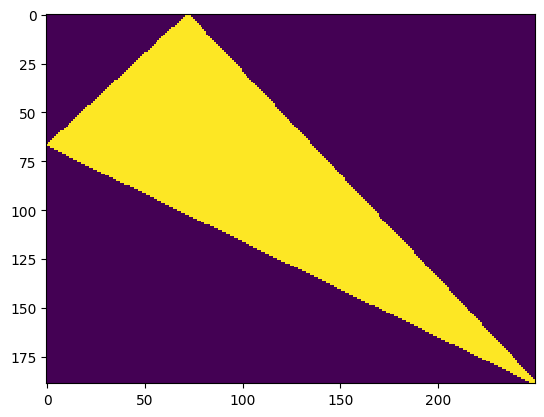

In [28]:
# display images 
plt.imshow(volume_slice, interpolation='nearest')
plt.show()